# Задача 4

Проверить мощность и консервативность критерия Уликоксона о равенстве медиан для выборок вида:

$ X1 \sim \alpha N(0,1) + (1 - \alpha) N(2, 4)$

$ X2 \sim \alpha N(0,1) + (1 - \alpha) N(2, 4) + \delta$

(гауссова смесь)

Изучить зависимость от $\alpha$ и $\delta$.

In [14]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.multitest import multipletests
from collections import Counter


%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 13

В соответствии с приведенными материалами, реализуем функцию, которая будет возвращать выборку из распределения

$$
\alpha N(0,1) + (1 - \alpha) N(2, 4) + \delta
$$

($\alpha$ и $\delta$ - будут параметрами функции)

In [4]:
distparams = np.array([[0., 1.], [2., 4.]])
def sample(n, alpha, delta):
    k = distparams.shape[0]
    weights = np.array([alpha, 1 - alpha])
    rs = np.random.RandomState()
    mixture_idx = rs.choice(k, size=n, replace=True, p=weights)
    X = np.fromiter((st.norm.rvs(*(distparams[i])) for i in mixture_idx), dtype=np.float64) + delta
    return X

**Пример:** Выборка размера 100 для $\alpha = 0.5, ~ \delta = 1$:

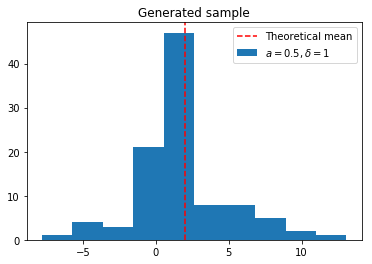

In [23]:
X = sample(100, 0.5, 1)
plt.title('Generated sample')
plt.hist(X, label='$a = 0.5, \delta = 1$')
plt.axvline(x=2 * (1 - 0.5) + 1, c='r', linestyle='--', label='Theoretical mean')
plt.legend()
_ = plt.show()

**Доп. замечание:** легко можно показать, что среднее такой случайной величины, сэмплируемой функцией `sample`, равна

$$
\mathbb{E} \xi = \alpha \mathbb{E} N(0,1) + (1 - \alpha) \mathbb{E} N(2,4) + \delta = 2(1 - \alpha) + \delta
$$

Это значение и отмечено на гистограмме.

Построим так же (для наглядности) зависимость распределения этой величины $\xi$ от параметра $\alpha$ (зависимость от $\delta$ тривиальна). Используем для этого KDE.


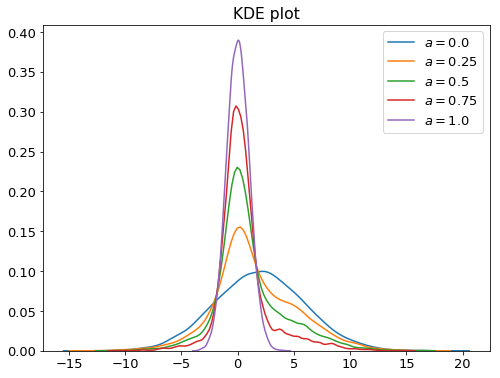

In [89]:
n = 10000
alphas = np.linspace(0, 1, 5)
for alpha in alphas:
    X = sample(n, alpha, 0)
    sns.kdeplot(X, label='$a = {}$'.format(alpha))
plt.title('KDE plot')
plt.legend()
_ = plt.show()

## Критерий Уилкоксона о равенстве медиан

$$
X1 = (X1_1, ..., X1_n), \quad X2 = (X2_1, ..., X2_n), \quad X1_i \neq X2_i \\
$$
$$ 
H_0: ~ med(X1 - X2) = 0 \\
H_1: ~ med(X1 - X2) \neq 0
$$
Статистика:
$$
W = \sum_{i=1}^{n}rank(|X1_i-X2_i|)~sign(X1_i-X2_i)
$$

### Наш случай

В нашем случае рассматривается случайная величина $\xi$ с двухпараметрическим распределением $F_{\alpha, \delta}(x) = F(\alpha, \delta)$.

$$
X \sim F(\alpha, 0) \\
Y \sim F(\alpha, \delta).
$$

Тогда $med(X - Y) = 0 \Leftrightarrow \delta = 0$, и гипотезы критерия представляются в виде:

$$
H_0: ~ \delta = 0 \\
H_1: ~ \delta \neq 0
$$

Его мощность, это $W = \mathbb{P}\{reject ~ H_0 | H_1 ~ is ~ true\} = W(\delta)$ — зависит от $\delta$, т.к. альтернатива сложная.

### Вычисление мощности

Зафиксируем $\alpha$ и $\delta$. Для практического вычисления мощности проведем следующий эксперимент:

- сгенерируем $m$ пар выборок, соответствующих альтернативной гипотезе ($H_1$): $~ Z = ((X_1, Y_1), ..., (X_m, Y_m))$;

- для каждой выборки проведем тест Уилкоксона и найдем *p-value*. На стандартном уровне значимости, определим, отвергается ли нулевая гипотеза. Доля отвергнутых гипотез и будет оценкой мощности.

В таком эксперименте мощность получается из выборочной оценки и вообще говоря, зависит от того, какие выборки будут сгенерированны — число отвергнутых гипотез может колебаться. Чтобы решить эту проблему, будем генерировать достаточно большие выборки (это должно решить проблему). Это так же должно увеличить мощность критерия.

#### Параметры эксперимента:

$$
m = 5000 \\
n = size(X_i) = size(Y_i) = 200 \\
\alpha = 0.5, \quad \delta = 1
$$

In [5]:
def generate_samples(m, n, alpha, d, hypothesis):
    # `hypothesis` определяет, в соответствии с какой гипотезой
    # генерируется выборка
    Z = []
    for i in range(m):
        X = sample(n, alpha, 0)
        if hypothesis == 'h1':
            Y = sample(n, alpha, d)
        else:
            Y = sample(n, alpha, 0)
        Z.append((X, Y))
    return np.array(Z)

In [6]:
a = 0.05
m = 5000
n = 200
alpha = 0.5
d = 1

Z = generate_samples(m, n, alpha, d, 'h1')

In [7]:
def count_rejections(Z, a):
    rejected = 0
    for X, Y in Z:
        rejected += st.wilcoxon(X, Y).pvalue <= a
    return rejected

In [90]:
W = count_rejections(Z, a) / m
W

0.9404

Получилась выборочная оценка мощности:$~W \approx 0.94$ — достаточно большое значение, тест **мощный**.

Консервативность теста может быть оценена аналогично:

In [8]:
Z_h0 = generate_samples(m, n, alpha, d, 'h0')

In [92]:
C = count_rejections(Z_h0, a) / m
C

0.0492

Видим, что оценка вероятности неверно отклонить нулевую гипотезу меньше уровня значимости $a = 0.05$ (c учетом случайности сэмплирования, не сильно превосходит). Это значит, тест **консервативен**.

### Поправка на множественность гипотез

In [9]:
def sample_pvalues(Z):
    pvals = []
    for X, Y in Z:
        pvals.append(st.wilcoxon(X, Y).pvalue)
    return np.array(pvals)

#### Поправка Бонферрони

(сильно понижает мощность критерия, как всегда)

In [106]:
pvalues = sample_pvalues(Z)
rejects = multipletests(pvalues, method='bonferroni', alpha=a)[0]

sum(rejects) / m

0.1578

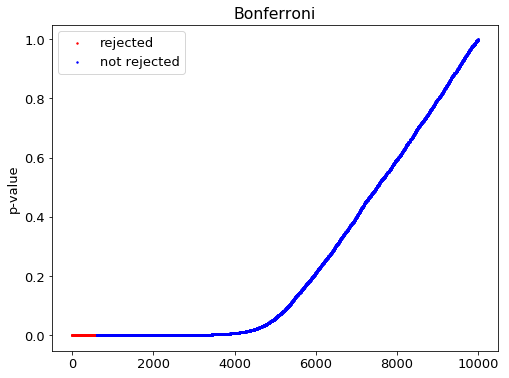

In [32]:
pvalues = sample_pvalues(np.concatenate([Z, Z_h0]))
pvalues.sort()
rejects = multipletests(pvalues, method='bonferroni', alpha=a, returnsorted=True)[0]
rejected = np.where(rejects==True)[0]
not_rejected = np.where(rejects==False)[0]

plt.title('Bonferroni')
plt.ylabel('p-value')
plt.scatter(rejected, pvalues[rejected], c='r', s=2, label='rejected')
plt.scatter(not_rejected, pvalues[not_rejected], c='b', s=2, label='not rejected')
plt.legend()
_ = plt.show()

#### Поправка Бенжамина-Йекутиели

In [37]:
pvalues = sample_pvalues(Z)
rejects = multipletests(pvalues, method='fdr_by', alpha=a)[0]

sum(rejects) / m

0.7226

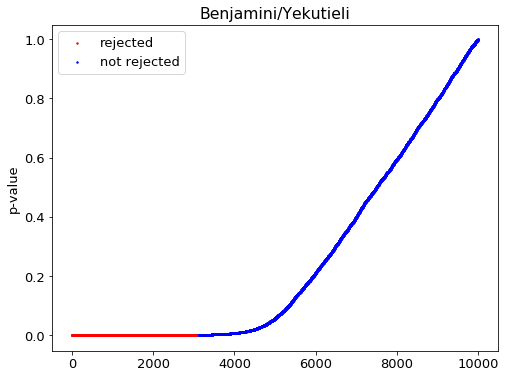

In [39]:
pvalues = sample_pvalues(np.concatenate([Z, Z_h0]))
pvalues.sort()
rejects = multipletests(pvalues, method='fdr_by', alpha=a, returnsorted=True)[0]
rejected = np.where(rejects==True)[0]
not_rejected = np.where(rejects==False)[0]

plt.title('Benjamini/Yekutieli')
plt.ylabel('p-value')
plt.scatter(rejected, pvalues[rejected], c='r', s=2, label='rejected')
plt.scatter(not_rejected, pvalues[not_rejected], c='b', s=2, label='not rejected')
plt.legend()
_ = plt.show()

#### Поправка Бенжамина-Хохберга

Хорошо сохраняет мощность.

In [30]:
pvalues = sample_pvalues(Z)
rejects = multipletests(pvalues, method='fdr_bh', alpha=a)[0]

sum(rejects) / m

0.9312

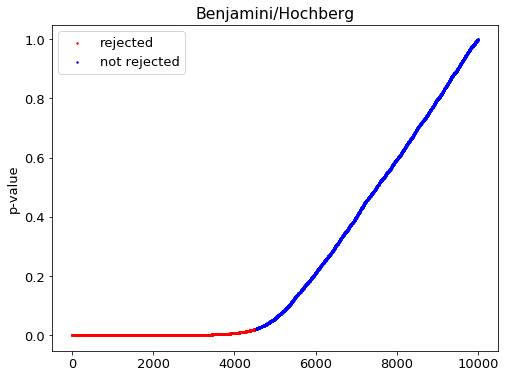

In [33]:
pvalues = sample_pvalues(np.concatenate([Z, Z_h0]))
pvalues.sort()
rejects = multipletests(pvalues, method='fdr_bh', alpha=a, returnsorted=True)[0]
rejected = np.where(rejects==True)[0]
not_rejected = np.where(rejects==False)[0]

plt.title('Benjamini/Hochberg')
plt.ylabel('p-value')
plt.scatter(rejected, pvalues[rejected], c='r', s=2, label='rejected')
plt.scatter(not_rejected, pvalues[not_rejected], c='b', s=2, label='not rejected')
plt.legend()
_ = plt.show()

**Вывод:** Будем пользоваться поправкой Бенжамина-Хохберга для оценки мощности.

In [40]:
def estimate_power(Z, a):
    pvalues = sample_pvalues(Z)
    rejects = multipletests(pvalues, method='fdr_bh', alpha=a, returnsorted=True)[0]
    return np.sum(rejects) / len(Z)

In [41]:
estimate_power(Z, a)

0.9312

$$
W \approx 0.93 \quad - тест ~ мощный
$$

### Зависимость от $\alpha$ и $\delta$

Изучим зависимость мощности от $\alpha$ и $\delta$. До этого мы фиксировали $\delta$, но вообще говоря, мощность зависит от выбора альтернативы. 

Построим зависимость $W(\delta)$:

(всё еще считаем равновероятными компоненты гауссовской смеси, т.е. $\alpha=0.5$)

*(немного поменяем параметры, чтобы не ждать результатов вечно)*

In [72]:
m = 1000
n = 50
a = 0.05
alpha = 0.5
deltas = np.linspace(-3, 3, 31)
powers = []
for d in deltas:
    Z = generate_samples(m, n, alpha, d, 'h1')
    powers.append(estimate_power(Z, a))

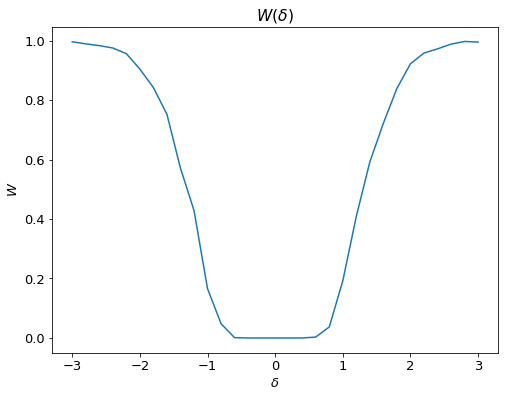

In [73]:
plt.title('$W(\delta)$')
plt.xlabel('$\delta$'), plt.ylabel('$W$')
plt.plot(deltas, powers)
_ = plt.show()

**Вывод:** Видим, что график (как и ожидалось) симметричен относительно нуля. На значениях $|\delta| > 3$ график выходит на плато $W \approx 1$ — при больших $\delta$ критерий хорошо различает выборки. На значениях $|\delta| < 0.5$ график так же не меняется, $W$ достигает нуля.

Построим данных график для различных значений $\alpha$.

In [80]:
m = 1000
n = 50
a = 0.05
alphas = np.linspace(0, 1, 4)
deltas = np.linspace(-3, 3, 31)
powers = {}
for alpha in alphas:
    powers[alpha] = []
    for d in deltas:
        Z = generate_samples(m, n, alpha, d, 'h1')
        powers[alpha].append(estimate_power(Z, a))

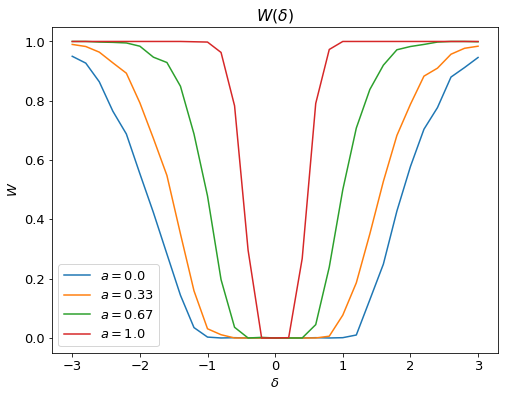

In [82]:
plt.title('$W(\delta)$')
plt.xlabel('$\delta$'), plt.ylabel('$W$')
for alpha, pows in powers.items():
    plt.plot(deltas, pows, label='$a = {}$'.format(round(alpha, 2)))
plt.legend(loc='best')
_ = plt.show()

**Вывод:** Таким образом, чем больше значение $\alpha$, тем больше преобладает слагаемое $N(0, 1)$ в распределении, и тем меньшее значение $\delta$ необходимо для того, чтобы получить мощный критерий.